In [1]:
# Ref. https://github.com/uclaacmai/Generative-Adversarial-Network-Tutorial/blob/master/Generative%20Adversarial%20Networks%20Tutorial.ipynb

#### loading dependencies

In [2]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### loading the data

In [3]:
!ls

bin						      lib64
etc						      MNIST_data
Generative_Adversarial_Network_with_TensorFlow.ipynb  pip-selfcheck.json
include						      pyvenv.cfg
lib						      share


In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets('MNIST_data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
!ls 

bin						      lib64
etc						      MNIST_data
Generative_Adversarial_Network_with_TensorFlow.ipynb  pip-selfcheck.json
include						      pyvenv.cfg
lib						      share


In [7]:
!ls MNIST_data/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [8]:
x_train = mnist.train.images[:55000,:]

In [9]:
x_train.shape

(55000, 784)

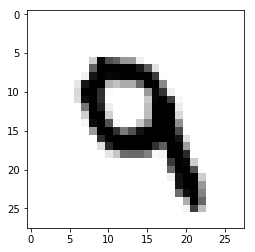

In [10]:
# lets look at what a random image might look like
randomNum = random.randint(0, 55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

#### defining our discriminator

In [11]:
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [12]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        #first conv and pool layers
        
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], 
                                      initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], 
                                      initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        
        h_pool1 = avg_pool_2x2(h_conv1)
        
        # second conv and pool layers
        
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        
        h_pool2 = avg_pool_2x2(h_conv2)
        
        # first full connected layer
        
        W_fc1 = tf.get_variable('d_wfc1', [7*7*16, 32], 
                               initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        
        # second full connected layer
        
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], 
                                initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))
        
        # final layer
        
        y_conv = (tf.matmul(h_fc1, W_fc2) + b_fc2)
    
    return y_conv         
        

In [13]:
# ?tf.get_variable # Gets an existing variable with these parameters or create a new one.

#### defining the generator

In [14]:
def generator(z, batch_size, z_dim, reuse=False):
    
    with tf.variable_scope('generator') as scope:
        if(reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64
        c_dim = 1
        s = 28
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16)
                
        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        
        # first deconv layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        
        W_conv1 = tf.get_variable('g_wconv1', 
                                  [5, 5, output1_shape[-1], int(h0.get_shape()[-1])],
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], 
                                 initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape,
                                        strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs= H_conv1, center=True, scale=True,
                                              is_training=True, scope='g_bn1')
        H_conv1 = tf.nn.relu(H_conv1)
        
        # second deconv layer
        
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], 
                                               int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], 
                                  initializer=tf.constant_initializer(.1))
        
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape,
                                        strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        
        H_conv2 = tf.contrib.layers.batch_norm(inputs=H_conv2, center=True, scale=True,
                                              is_training=True, scope='g_bn2')
        
        H_conv2 = tf.nn.relu(H_conv2)
        
        # third deconv layer 
        
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], 
                                                    int(H_conv2.get_shape()[-1])],
                                        initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], 
                                 initializer=tf.constant_initializer(.1))
        
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape,
                                        strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        
        H_conv3 = tf.contrib.layers.batch_norm(inputs=H_conv3, center=True, scale=True,
                                              is_training=True, scope='g_bn3')
        
        H_conv3 = tf.nn.relu(H_conv3)
        
        # fourth deconv layer
        
        output4_shape = [batch_size, s, s, c_dim]
        
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])],
                                 initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], 
                                 initializer=tf.constant_initializer(.1))
        
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape,
                                        strides=[1, 2, 2, 1], padding='VALID') + b_conv4
        
        H_conv4 = tf.nn.tanh(H_conv4)
        
    return H_conv4

In [15]:
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [16]:
sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1, z_dimensions])

In [17]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

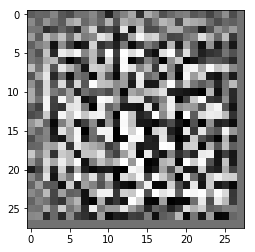

In [18]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

#### training a GAN

In [19]:
batch_size = 16
tf.reset_default_graph() #since we change batchsize from 1 to 16, reset tensorflow graph

In [20]:
sess = tf.Session()
x_placeholder = tf.placeholder('float', shape = [None, 28,28,1]) #images for discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) # images for input noise generator

In [21]:
Dx = discriminator(x_placeholder)
Gz = generator(z_placeholder, batch_size, z_dimensions)
Dg = discriminator(Gz, reuse=True)

In [22]:
# loss for generator

In [23]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [24]:
# loss for discriminator 

In [25]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [26]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [27]:
print(tf.get_variable_scope().reuse)

False


In [28]:
adam = tf.train.AdamOptimizer()
trainerD = adam.minimize(d_loss, var_list=d_vars)
trainerG = adam.minimize(g_loss, var_list=g_vars)

In [29]:
import time
start_time = time.time()

In [30]:
sess.run(tf.global_variables_initializer())
iterations = 3000
for i in range(iterations):
    z_batch = np.random.normal(-1,1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0], [batch_size, 28, 28, 1])
    _, dLoss = sess.run([trainerD, d_loss], feed_dict={z_placeholder:z_batch, x_placeholder:real_image_batch})
    _, gLoss = sess.run([trainerG, g_loss], feed_dict={z_placeholder:z_batch})

duration_compilation =  932.1604962348938


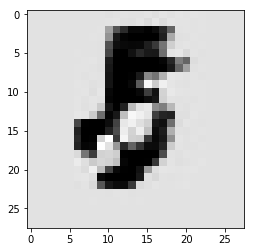

In [31]:
final_time = time.time()
print('duration_compilation = ', final_time - start_time)
sample_image = generator(z_placeholder, 1, z_dimensions, True)
z_batch = np.random.normal(-1,1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder:z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')